# Parallel demand forecasting at scale using Ray Tune

**Batch training and tuning** are common tasks in machine learning use-cases. They require training simple models, on data batches, typcially corresponding to different locations, products, etc. Batch training can take less time to process all the data at once, but only if those batches can run in parallel!

This notebook showcases how to conduct batch forecasting with [Prophet](https://github.com/facebook/prophet) and [ARIMA](https://github.com/Nixtla/statsforecast). **Prophet** is a popular open-source library developed by Facebook and designed for automatic forecasting of univariate time series data. **ARIMA** is an older, well-known algorithm for forecasting univariate time series at less fine-grained detail than Prophet.

![Batch training diagram](../../data/examples/images/batch-training.svg)

For the data, we will use the [NYC Taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). This popular tabular dataset contains historical taxi pickups by timestamp and location in NYC.

For the training, we will train a separate forecasting model to predict #pickups at each location in NYC at daily level for the next 28 days. Specifically, we will use the `pickup_location_id` column in the dataset to group the dataset into data batches. Then we will conduct an experiment for each location, to find the best either Prophet or ARIMA model, per location.

# Contents

In this this tutorial, you will learn how to:
 1. [Define how to load and prepare Parquet data](#prepare_data2)
 2. [Define a Trainable (callable) function](#define_trainable2)
 3. [Run batch training and inference with Ray Tune](#run_tune_search2)
 4. [Load a model from checkpoint](#load_checkpoint2)
 5. [Create a forecast from model restored from checkpoint](#create_prediction2)


# Walkthrough

```{tip}
Prerequisite for this notebook: Read the [Key Concepts](tune-60-seconds) page for Ray Tune.
```

First, let's make sure we have all Python packages we need installed.

In [1]:
!pip install -q "ray[air]" scikit-learn prophet statsmodels statsforecast

Next, let's import a few required libraries, including open-source [Ray](https://github.com/ray-project/ray) itself!

In [2]:
import os

num_cpu = os.cpu_count()

print(f"Number of CPUs in this system: {num_cpu}")
from typing import Tuple, List, Union, Optional, Callable
from datetime import datetime, timedelta
import time
import pandas as pd
import numpy as np

print(f"numpy: {np.__version__}")
import matplotlib.pyplot as plt

%matplotlib inline
import scipy

print(f"scipy: {scipy.__version__}")
import pyarrow
import pyarrow.parquet as pq
import pyarrow.dataset as pds

print(f"pyarrow: {pyarrow.__version__}")

Number of CPUs in this system: 64
numpy: 1.24.3
scipy: 1.9.1
pyarrow: 11.0.0


In [3]:
import ray

if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-05-17 14:24:46,542	INFO worker.py:1380 -- Using address localhost:9031 set in the environment variable RAY_ADDRESS
find: ‘.git’: No such file or directory
2023-05-17 14:24:47,257	INFO worker.py:1498 -- Connecting to existing Ray cluster at address: 172.31.213.59:9031...
2023-05-17 14:24:47,273	INFO worker.py:1673 -- Connected to Ray cluster. View the dashboard at https://console.anyscale.com/api/v2/sessions/ses_jgkdnu2723aleytwqqhebr12vs/services?redirect_to=dashboard 
2023-05-17 14:24:47,296	INFO packaging.py:347 -- Pushing file package 'gcs://_ray_pkg_e219f8b9b77b196e3d63ced7d9917421.zip' (5.45MiB) to Ray cluster...
2023-05-17 14:24:47,314	INFO packaging.py:360 -- Successfully pushed file package 'gcs://_ray_pkg_e219f8b9b77b196e3d63ced7d9917421.zip'.


Python version:,3.8.13
Ray version:,3.0.0.dev0
Dashboard:,http://console.anyscale.com/api/v2/sessions/ses_jgkdnu2723aleytwqqhebr12vs/services?redirect_to=dashboard


In [4]:
print(ray.cluster_resources())

{'memory': 319463062119.0, 'object_store_memory': 141198455193.0, 'CPU': 64.0, 'node:172.31.213.59': 1.0, 'accelerator_type:V100': 1.0, 'GPU': 8.0}


In [5]:
# Import forecasting libraries.
import prophet
from prophet import Prophet

print(f"prophet: {prophet.__version__}")

import statsforecast
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

print(f"statsforecast: {statsforecast.__version__}")

# Import ray libraries.
from ray import train, tune, serve
from ray.train import Checkpoint, ScalingConfig

RAY_IGNORE_UNHANDLED_ERRORS = 1

prophet: 1.1.3
statsforecast: 1.5.0


In [6]:
# For benchmarking purposes, we can print the times of various operations.
# In order to reduce clutter in the output, this is set to False by default.
PRINT_TIMES = False


def print_time(msg: str):
    if PRINT_TIMES:
        print(msg)


# To speed things up, we’ll only use a small subset of the full dataset consisting of two last months of 2019.
# You can choose to use the full dataset for 2018-2019 by setting the SMOKE_TEST variable to False.
SMOKE_TEST = True

## Define how to load and prepare Parquet data <a class="anchor" id="prepare_data2"></a>

First, we need to load some data. Since the NYC Taxi dataset is fairly large, we will filter files first into a PyArrow dataset. And then in the next cell after, we will filter the data on read into a PyArrow table and convert that to a pandas dataframe.

```{tip}
Use PyArrow dataset and table for reading or writing large parquet files, since its native multithreaded C++ adapter is faster than pandas read_parquet, even using engine=pyarrow.
```

In [7]:
# Define some global variables.
TARGET = "y"
FORECAST_LENGTH = 28
MAX_DATE = datetime(2019, 6, 30)
s3_partitions = pds.dataset(
    "s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/",
    partitioning=["year", "month"],
)
s3_files = [f"s3://anonymous@{file}" for file in s3_partitions.files]

# Obtain all location IDs
all_location_ids = (
    pq.read_table(s3_files[0], columns=["pickup_location_id"])["pickup_location_id"]
    .unique()
    .to_pylist()
)
# drop [264, 265, 199]
all_location_ids.remove(264)
all_location_ids.remove(265)
all_location_ids.remove(199)

# Use smoke testing or not.
starting_idx = -2 if SMOKE_TEST else 0
# TODO: drop location 199 to test error-handling before final git checkin
sample_locations = [141, 229, 173] if SMOKE_TEST else all_location_ids

# Display what data will be used.
s3_files = s3_files[starting_idx:]
print(f"NYC Taxi using {len(s3_files)} file(s)!")
print(f"s3_files: {s3_files}")
print(f"Locations: {sample_locations}")

NYC Taxi using 2 file(s)!
s3_files: ['s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2019/05/data.parquet/359c21b3e28f40328e68cf66f7ba40e2_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2019/06/data.parquet/ab5b9d2b8cc94be19346e260b543ec35_000000.parquet']
Locations: [141, 229, 173]


In [8]:
############
# STEP 1.  Define Python functions to
#          a) read and prepare a segment of data, and
############

# Function to read a pyarrow.Table object using pyarrow parquet
def read_data(file: str, sample_id: np.int32) -> pd.DataFrame:

    # parse out min expected date
    part_zero = "s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/"
    split_text = file.split(part_zero)[1]
    min_year = split_text.split("/")[0]
    min_month = split_text.split("/")[1]
    string_date = min_year + "-" + min_month + "-" + "01" + " 00:00:00"
    min_date = datetime.strptime(string_date, "%Y-%m-%d %H:%M:%S")

    df = pq.read_table(
        file,
        filters=[
            ("pickup_at", ">", min_date),
            ("pickup_at", "<=", MAX_DATE),
            ("passenger_count", ">", 0),
            ("trip_distance", ">", 0),
            ("fare_amount", ">", 0),
            ("pickup_location_id", "not in", [264, 265]),
            ("dropoff_location_id", "not in", [264, 265]),
            ("pickup_location_id", "=", sample_id),
        ],
        columns=[
            "pickup_at",
            "dropoff_at",
            "pickup_location_id",
            "dropoff_location_id",
            "passenger_count",
            "trip_distance",
            "fare_amount",
        ],
    ).to_pandas()
    return df


# Function to transform a pandas dataframe
def transform_df(input_df: pd.DataFrame) -> pd.DataFrame:
    df = input_df.copy()

    # calculate trip_duration
    df["trip_duration"] = (df["dropoff_at"] - df["pickup_at"]).dt.seconds
    # filter trip_durations > 1 minute and less than 24 hours
    df = df[df["trip_duration"] > 60]
    df = df[df["trip_duration"] < 24 * 60 * 60]

    # Prophet requires timstamp is 'ds' and target_value name is 'y'
    # Prophet requires at least 2 data points per timestamp
    # StatsForecast requires location name is 'unique_id'

    # add year_month_day and concat into a unique column to use as groupby key
    df["ds"] = df["pickup_at"].dt.to_period("D").dt.to_timestamp()
    df["loc_year_month_day"] = (
        df["pickup_location_id"].astype(str)
        + "_"
        + df["pickup_at"].dt.year.astype(str)
        + "_"
        + df["pickup_at"].dt.month.astype(str)
        + "_"
        + df["pickup_at"].dt.day.astype(str)
    )
    # add target_value quantity for groupby count later
    df["y"] = 1
    # rename pickup_location_id to unique_id
    df.rename(columns={"pickup_location_id": "unique_id"}, inplace=True)
    # keep only necessary columns
    df = df[["loc_year_month_day", "unique_id", "ds", "y"]].copy()

    # groupby aggregregate
    g = df.groupby("loc_year_month_day").agg({"unique_id": min, "ds": min, "y": sum})
    # having num rows in group > 2
    g.dropna(inplace=True)
    g = g[g["y"] > 2].copy()

    # Drop groupby variable since we do not need it anymore
    g.reset_index(inplace=True)
    g.drop(["loc_year_month_day"], axis=1, inplace=True)

    return g


def prepare_data(sample_location_id: np.int32) -> pd.DataFrame:

    # Load data.
    df_list = [read_data(f, sample_location_id) for f in s3_files]
    df_raw = pd.concat(df_list, ignore_index=True)
    # Abort Tune to avoid Tune Error if df has too few rows
    if df_raw.shape[0] < FORECAST_LENGTH:
        print_time(f"Location {sample_location_id} has only {df_raw.shape[0]} rows")
        train.report(dict(error=None))
        return None

    # Transform data.
    df = transform_df(df_raw)
    # Abort Tune to avoid Tune Error if df has too few rows
    if df.shape[0] < FORECAST_LENGTH:
        print_time(f"Location {sample_location_id} has only {df.shape[0]} rows")
        train.report(dict(error=None))
        return None
    else:
        df.sort_values(by="ds", inplace=True)

    return df

## Define a Trainable (callable) function <a class="anchor" id="define_trainable2"></a>

Next, we define a trainable function, called `train_model()`, in order to train and evaluate a model on a data partition. This function will be called *in parallel for every permutation* in the Tune search space! 

Inside this trainable function:
- 📖 The input must include a `config` argument. 
- 📈 Inside the function, the tuning metric (a model's loss or error) must be calculated and reported using `session.report()`.
- ✔️ Optionally [checkpoint](checkpoint-api-ref) (save) the model for fault tolerance and easy deployment later.

```{tip}
Ray Tune has two ways of [defining a trainable](tune_60_seconds_trainables), namely the Function API and the Class API. Both are valid ways of defining a trainable, but *the Function API is generally recommended*.
```

In [9]:
############
# STEP 1.  Define Python functions to
#          b) train and evaluate a model on a segment of data.
############


def evaluate_model_prophet(
    model: "prophet.forecaster.Prophet",
) -> Tuple[float, pd.DataFrame]:

    # Inference model using FORECAST_LENGTH.
    future_dates = model.make_future_dataframe(periods=FORECAST_LENGTH, freq="D")
    future = model.predict(future_dates)

    # Calculate mean absolute forecast error.
    temp = future.copy()
    temp["forecast_error"] = np.abs(temp["yhat"] - temp["trend"])
    error = np.mean(temp["forecast_error"])

    return error, future


def evaluate_model_statsforecast(
    model: "statsforecast.models.AutoARIMA", test_df: pd.DataFrame
) -> Tuple[float, pd.DataFrame]:

    # Inference model using test data.
    forecast = model.forecast(FORECAST_LENGTH + 1).reset_index()
    forecast.set_index(["ds"], inplace=True)
    test_df.set_index("ds", inplace=True)
    future = pd.concat([test_df, forecast[["AutoARIMA"]]], axis=1)
    future.dropna(inplace=True)
    future.columns = ["unique_id", "trend", "yhat"]

    # Calculate mean absolute forecast error.
    temp = future.copy()
    temp["forecast_error"] = np.abs(temp["yhat"] - temp["trend"])
    error = np.mean(temp["forecast_error"])

    return error, future


# 2. Define a custom train function
def train_model(config: dict) -> None:

    # Get Tune parameters
    sample_location_id = config["params"]["location"]
    model_type = config["params"]["algorithm"]

    # Define Prophet model with 75% confidence interval
    if model_type == "prophet_additive":
        model = Prophet(interval_width=0.75, seasonality_mode="additive")
    elif model_type == "prophet_multiplicative":
        model = Prophet(interval_width=0.75, seasonality_mode="multiplicative")

    # Define ARIMA model with daily frequency which implies seasonality = 7
    elif model_type == "arima":
        model = [AutoARIMA(season_length=7, approximation=True)]

    # Read and transform data.
    df = prepare_data(sample_location_id)

    # Train model.
    if model_type == "arima":

        try:
            # split data into train, test.
            train_end = df.ds.max() - timedelta(days=FORECAST_LENGTH + 1)
            train_df = df.loc[(df.ds <= train_end), :].copy()
            test_df = df.iloc[-FORECAST_LENGTH:, :].copy()

            # fit AutoARIMA.
            model = StatsForecast(df=train_df, models=model, freq="D")

            # Inference model and evaluate error.
            error, future = evaluate_model_statsforecast(model, test_df)
        except:
            print(f"ARIMA error processing location: {sample_location_id}")

    else:  # model type is Prophet
        try:
            # fit Prophet.
            model = model.fit(df[["ds", "y"]])

            # Inference model and evaluate error.
            error, future = evaluate_model_prophet(model)
        except:
            print(f"Prophet error processing location: {sample_location_id}")

    # Define a model checkpoint using AIR API.
    # https://docs.ray.io/en/latest/tune/tutorials/tune-checkpoints.html
    checkpoint = Checkpoint.from_dict(
        {
            "model": model,
            "forecast_df": future,
            "location_id": sample_location_id,
        }
    )

    # Save checkpoint and report back metrics, using ray.train.report()
    # The metrics you specify here will appear in Tune summary table.
    # They will also be recorded in Tune results under `metrics`.
    metrics = dict(error=error)
    train.report(metrics, checkpoint=checkpoint)

## Run batch training on Ray Tune <a class="anchor" id="run_tune_search2"></a>

**Recall what we are doing, high level, is training several different models per pickup location.** We are using Ray Tune so we can *run all these trials in parallel* on a Ray cluster. At the end, we will inspect the results of the experiment and deploy only the best model per pickup location.

**Step 1. Define Python functions to read and prepare a segment of data and train and evaluate one or many models per segment of data**.  We already did this, above.

**Step 2. Scaling**:
Below, we specify training resources in a `ray.train.ScalingConfig` object inside the Tune search space.  For more information about configuring resource allocations, see [A Guide To Parallelism and Resources](tune-parallelism). 

**Step 3. Search Space**:
Below, we define our [Tune search space](tune-key-concepts-search-spaces), which consists of:
- Different algorithms, either:
  - Prophet with [multiplicative or additive](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html) seasonal effects 
  - [AutoARIMA](https://github.com/Nixtla/statsforecast).
- NYC taxi pick-up locations.
- Scaling config

**Step 4. Search Algorithm or Strategy**:
Below, our Tune jobs will be defined using a search space and simple grid search. 
> The typical use case for Tune search spaces is for hyperparameter tuning. In our case, we are defining the Tune search space in order to run distributed tuning jobs automatically.  Each training job will use a different data partition (taxi pickup location), different algorithm, and the compute resources we defined in the Scaling config.

**Step 5. Now we are ready to kick off a Ray Tune experiment!** 
- Define a `tuner` object.
- Put the training function `train_model()` inside the `tuner` object.
- Run the experiment using `tuner.fit()`.

💡 After you run the cell below, right-click on it and choose "Enable Scrolling for Outputs"! This will make it easier to view, since tuning output can be very long!

**Setting SMOKE_TEST=False, running on Anyscale: 771 models, using 18 NYC Taxi S3 files dating from 2018/01 to 2019/06 (split into partitions approx 1GiB each), were simultaneously trained on a 7-node AWS cluster of m5.4xlarges, within 40 minutes.**

In [10]:
############
# STEP 2. Customize distributed compute scaling.
############
num_training_workers = min(num_cpu - 2, 32)
scaling_config = ScalingConfig(
    # Number of distributed workers.
    num_workers=num_training_workers,
    # Turn on/off GPU.
    use_gpu=False,
    # Specify resources used for trainer.
    trainer_resources={"CPU": 1},
    # Try to schedule workers on different nodes.
    placement_strategy="SPREAD",
)

############
# STEP 3. Define a search space dict of all config parameters.
############
SEARCH_SPACE = {
    "scaling_config": scaling_config,
    "params": {
        "algorithm": tune.grid_search(
            ["prophet_additive", "prophet_multiplicative", "arima"]
        ),
        "location": tune.grid_search(sample_locations),
    },
}

# Optional STEP 4. Specify the hyperparameter tuning search strategy.

############
# STEP 5. Run the experiment with Ray AIR APIs.
# https://docs.ray.io/en/latest/ray-air/examples/huggingface_text_classification.html
############
start = time.time()

# Define a tuner object.
tuner = tune.Tuner(
    train_model,
    param_space=SEARCH_SPACE,
    tune_config=tune.TuneConfig(
        metric="error",
        mode="min",
    ),
    run_config=train.RunConfig(
        # Redirect logs to relative path instead of default ~/ray_results/.
        storage_path="my_Tune_logs",
        # Specify name to make logs easier to find in log path.
        name="ptf_nyc",
    ),
)

# Fit the tuner object.
results = tuner.fit()

total_time_taken = time.time() - start
print(f"Total number of models: {len(results)}")
print(f"TOTAL TIME TAKEN: {total_time_taken/60:.2f} minutes")

# Total number of models: 771
# TOTAL TIME TAKEN: 44.64 minutes

(train_model pid=14121) 14:25:05 - cmdstanpy - INFO - Chain [1] start processing
(train_model pid=14121) 14:25:06 - cmdstanpy - INFO - Chain [1] done processing


Trial name,date,done,error,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
train_model_42de5_00000,2023-05-17_14-25-07,True,502.849,"0_algorithm=prophet_additive,location=141",ip-172-31-213-59,1,172.31.213.59,14115,True,5.73623,5.73623,5.73623,1684358707,1,42de5_00000
train_model_42de5_00001,2023-05-17_14-25-07,True,483.067,"1_algorithm=prophet_multiplicative,location=141",ip-172-31-213-59,1,172.31.213.59,14116,True,5.94609,5.94609,5.94609,1684358707,1,42de5_00001
train_model_42de5_00002,2023-05-17_14-25-23,True,342.35,"2_algorithm=arima,location=141",ip-172-31-213-59,1,172.31.213.59,14117,True,21.574,21.574,21.574,1684358723,1,42de5_00002
train_model_42de5_00003,2023-05-17_14-25-07,True,539.389,"3_algorithm=prophet_additive,location=229",ip-172-31-213-59,1,172.31.213.59,14118,True,5.54851,5.54851,5.54851,1684358707,1,42de5_00003
train_model_42de5_00004,2023-05-17_14-25-07,True,529.743,"4_algorithm=prophet_multiplicative,location=229",ip-172-31-213-59,1,172.31.213.59,14119,True,5.4158,5.4158,5.4158,1684358707,1,42de5_00004
train_model_42de5_00005,2023-05-17_14-25-22,True,480.844,"5_algorithm=arima,location=229",ip-172-31-213-59,1,172.31.213.59,14122,True,20.862,20.862,20.862,1684358722,1,42de5_00005
train_model_42de5_00006,2023-05-17_14-25-06,True,2.55585,"6_algorithm=prophet_additive,location=173",ip-172-31-213-59,1,172.31.213.59,14120,True,4.70871,4.70871,4.70871,1684358706,1,42de5_00006
train_model_42de5_00007,2023-05-17_14-25-06,True,2.52897,"7_algorithm=prophet_multiplicative,location=173",ip-172-31-213-59,1,172.31.213.59,14121,True,4.64482,4.64482,4.64482,1684358706,1,42de5_00007
train_model_42de5_00008,2023-05-17_14-25-22,True,2.81589,"8_algorithm=arima,location=173",ip-172-31-213-59,1,172.31.213.59,14123,True,21.2637,21.2637,21.2637,1684358722,1,42de5_00008


2023-05-17 14:25:23,079	INFO tune.py:1100 -- Total run time: 30.71 seconds (29.24 seconds for the tuning loop).


Total number of models: 9
TOTAL TIME TAKEN: 0.51 minutes


## Load a model from checkpoint  <a class="anchor" id="load_checkpoint2"></a>

- After the Tune experiment has finished, we can assemble the Tune {doc}`ResultGrid </tune/examples/tune_analyze_results>` object into a pandas dataframe.

- Next, we'll sort the pandas dataframe by pickuplocation and error, and keep only the best model with minimum error per pickup location.

In [11]:
# get a list of training loss errors
errors = [i.metrics.get("error", 10000.0) for i in results]

# get a list of checkpoints
checkpoints = [i.checkpoint for i in results]

# get a list of locations
locations = [i.config["params"]["location"] for i in results]

# get a list of model params
algorithm = [i.config["params"]["algorithm"] for i in results]

# Assemble a pandas dataframe from Tune results
results_df = pd.DataFrame(
    zip(locations, errors, algorithm, checkpoints),
    columns=["location_id", "error", "algorithm", "checkpoint"],
)
results_df.head(8)

,location_id,error,algorithm,checkpoint
0,141,502.848601,prophet_additive,Checkpoint(local_path=/home/ray/default/doc/so...
1,141,483.067259,prophet_multiplicative,Checkpoint(local_path=/home/ray/default/doc/so...
2,141,342.350202,arima,Checkpoint(local_path=/home/ray/default/doc/so...
3,229,539.389339,prophet_additive,Checkpoint(local_path=/home/ray/default/doc/so...
4,229,529.743081,prophet_multiplicative,Checkpoint(local_path=/home/ray/default/doc/so...
5,229,480.844291,arima,Checkpoint(local_path=/home/ray/default/doc/so...
6,173,2.555847,prophet_additive,Checkpoint(local_path=/home/ray/default/doc/so...
7,173,2.528968,prophet_multiplicative,Checkpoint(local_path=/home/ray/default/doc/so...


In [12]:
# Keep only 1 model per location_id with minimum error
final_df = results_df.copy()
final_df = final_df.loc[(final_df.error > 0), :]
final_df = final_df.loc[final_df.groupby("location_id")["error"].idxmin()]
final_df.sort_values(by=["error"], inplace=True)
final_df.set_index("location_id", inplace=True, drop=True)
final_df

,error,algorithm,checkpoint
location_id,,,
173,2.528968,prophet_multiplicative,Checkpoint(local_path=/home/ray/default/doc/so...
141,342.350202,arima,Checkpoint(local_path=/home/ray/default/doc/so...
229,480.844291,arima,Checkpoint(local_path=/home/ray/default/doc/so...


In [13]:
final_df[["algorithm"]].value_counts(normalize=True)

algorithm             
arima                     0.666667
prophet_multiplicative    0.333333
dtype: float64

## Create a forecast from model restored from checkpoint <a class="anchor" id="create_prediction2"></a>


Finally, we will restore the best and worst models from checkpoint, generate predictions, and inspect the forecasts. 

Prophet includes a convenient plot library which displays actual data along with backtest predictions and confidence intervals and future forecasts. With ARIMA, you have to create a prediciton manually.

- We will easily obtain AIR Checkpoint objects from the Tune results. 
- We will restore a Prophet or ARIMA model directly from checkpoint, and demonstrate it can be used for prediction.

```{tip}
Ray AIR Predictors make batch inference easy since they have internal logic to parallelize the inference.
```


checkpoint type:: <class 'ray.air.checkpoint.Checkpoint'>
location 173, algorithm prophet_multiplicative, best error 2.528968219366575


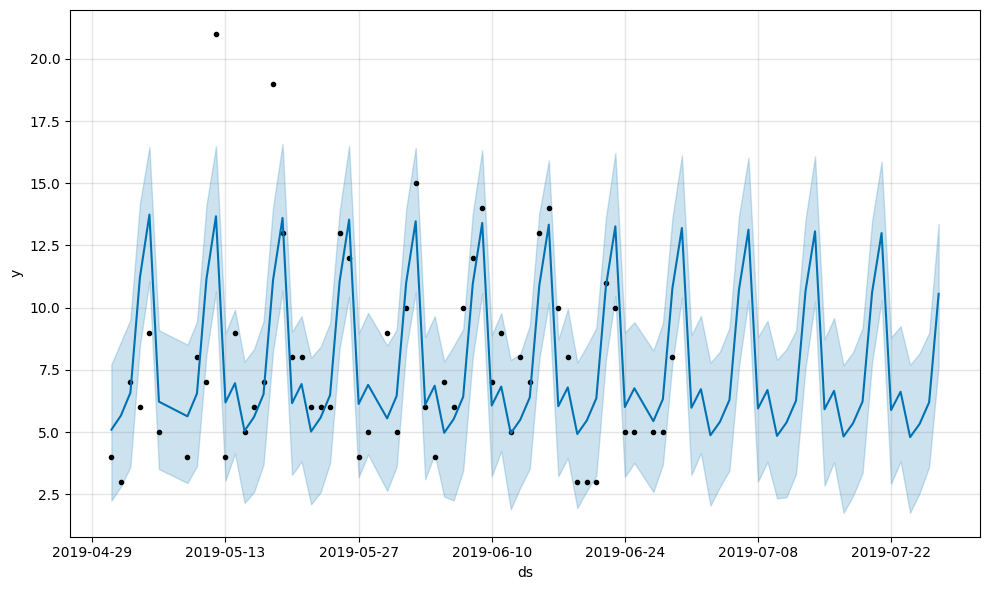

In [14]:
# Get the pickup location for the best model
if SMOKE_TEST:
    sample_location_id = final_df.index[0]
else:
    sample_location_id = final_df.index[120]

# Get the algorithm used
sample_algorithm = final_df.loc[[sample_location_id]].algorithm.values[0]

# Get a checkpoint directly from the pandas dataframe of Tune results
checkpoint = final_df.checkpoint[sample_location_id]
print(f"checkpoint type:: {type(checkpoint)}")

# Restore a model from checkpoint
sample_model = checkpoint.to_dict()["model"]

# Prophet .fit() performs inference + prediction.
# Arima train only performs inference; prediction is an extra step.
if sample_algorithm == "arima":
    prediction = (
        sample_model.forecast(2 * (FORECAST_LENGTH + 1)).reset_index().set_index("ds")
    )
    prediction["trend"] = None
    prediction.rename(columns={"AutoARIMA": "yhat"}, inplace=True)
    prediction = prediction.tail(FORECAST_LENGTH + 1)

# Restore already-created predictions from model training and eval
forecast_df = checkpoint.to_dict()["forecast_df"]

# Print pickup location ID, algorithm used, and model validation error.
sample_error = final_df.loc[[sample_location_id]].error.values[0]
print(
    f"location {sample_location_id}, algorithm {sample_algorithm}, best error {sample_error}"
)

# Plot forecast prediction using best model for this pickup location ID.
# If prophet model, use prophet built-in plot
if sample_algorithm == "arima":
    forecast_df[["trend", "yhat"]].plot()
else:
    plot1 = sample_model.plot(forecast_df)

checkpoint type:: <class 'ray.air.checkpoint.Checkpoint'>


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
/home/ray/anaconda3/lib/python3.8/site-packages/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 1]
  warnings.warn(
/home/ray/anaconda3/lib/python3.8/site-packages/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ray/anaconda3/lib/python3.8/site-packages/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ray/anaconda3/lib/python3.8/site-packages/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ray/anaconda3/lib/python3.8/site-packages/statsforecast/arima.py:914: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ray/anaconda3/lib/python3.8/site-packages/statsforecast/arima.py:914: UserWarning: possible convergence problem: minim

location 141, algorithm arima, best error 342.35020228794644


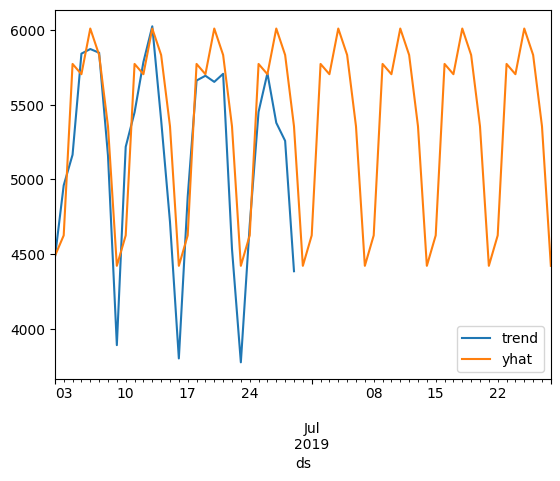

In [15]:
# Get the pickup location for the worst model
sample_location_id = final_df.index[len(final_df) - 2]

# Get the algorithm used
sample_algorithm = final_df.loc[[sample_location_id]].algorithm.values[0]

# Get a checkpoint directly from the pandas dataframe of Tune results
checkpoint = final_df.checkpoint[sample_location_id]
print(f"checkpoint type:: {type(checkpoint)}")

# Restore a model from checkpoint
sample_model = checkpoint.to_dict()["model"]

# Prophet .fit() performs inference + prediction.
# Arima train only performs inference; prediction is an extra step.
if sample_algorithm == "arima":
    prediction = (
        sample_model.forecast(2 * (FORECAST_LENGTH + 1)).reset_index().set_index("ds")
    )
    prediction["trend"] = None
    prediction.rename(columns={"AutoARIMA": "yhat"}, inplace=True)
    prediction = prediction.tail(FORECAST_LENGTH + 1)

# Restore already-created inferences from model training and eval
forecast_df = checkpoint.to_dict()["forecast_df"]

# Append the prediction to the inferences
forecast_df = pd.concat([forecast_df, prediction])

# Print pickup location ID, algorithm used, and model validation error.
sample_error = final_df.loc[[sample_location_id]].error.values[0]
print(
    f"location {sample_location_id}, algorithm {sample_algorithm}, best error {sample_error}"
)

# Plot forecast prediction using best model for this pickup location ID.
if sample_algorithm == "arima":
    forecast_df[["trend", "yhat"]].plot()
else:
    plot1 = sample_model.plot(forecast_df)